# Federated quantum neural network


In [ ]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 462 kB 44.4 MB/s 
     |████████████████████████████████| 3.8 MB 29.2 MB/s 
     |████████████████████████████████| 2.9 MB 47.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68718 sha256=5f8b14ab08031217db814adad7f53b1c70fcea704fea9db1b4b0ca71fa0e683d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstalling grpcio-1.42.0:
      Successfully uninstalled grpcio-1.42.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

We first import the packages we need

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
from cirq.contrib.svg import SVGCircuit
rng = np.random.default_rng(1234)


## Loading data

In [ ]:
def filter_12(x, y):
  """
  Enable to filter the numbers 1 and 2 in Mnist
  Return the dataset filtered
  """
  keep = (y == 1) | (y == 2)
  x, y = x[keep], y[keep]
  y = y == 0 #transform y into a boolean
  return x,y

In [ ]:
def load_dataset(nb_clients):
    """
    Input : number of client
    Output : the train, validation and test dataset from Mnist
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    assert x_train.shape == (60000, 28, 28)
    assert x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,)
    assert y_test.shape == (10000,)
    
    x_train,y_train=filter_12(x_train,y_train)
    x_test,y_test=filter_12(x_test, y_test)
    # x_train = x_train[:10000]
    # y_train = y_train[:10000]
    
    
    
    train, valid, test = [], [], tf.data.Dataset.from_tensor_slices((np.array([]),np.array([])))
    prop = 0.25
    length = x_train.shape[0]//nb_clients
    
    for i in range(nb_clients):
        choice = np.random.choice(range(x_train.shape[0]), size=(length,), replace=False)    
        ind = np.zeros(x_train.shape[0], dtype=bool)
        ind[choice] = True
        rest = ~ind
        
        tmpx = x_train[ind]
        tmpy = y_train[ind]
        
        size = int(tmpx.shape[0]*(1-prop))
    
        X_train_client,Y_train_client = np.array(tmpx[:size]),np.array(tmpy[:size])
        X_valid_client,Y_valid_client = np.array(tmpx[size:]),np.array(tmpy[size:])
        
        train.append((X_train_client,Y_train_client))
        valid.append((X_valid_client,Y_valid_client))
        
    test = (x_test,y_test)
        
    return train, valid, test
train, valid, test = load_dataset(2)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = [], [], [], [], test[0], test[1]

for i in range(len(train)):
  x_train.append(train[i][0][..., np.newaxis]/255.0)
  y_train.append(train[i][1])

  x_valid.append(valid[i][0][..., np.newaxis]/255.0)
  y_valid.append(valid[i][1])


x_test = x_test[..., np.newaxis]/255.0

print("Number of original training examples :",[len(x) for x in x_train])
print("Number of original validation examples :",[len(x) for x in x_valid])
print("Number of original test examples :",len(x_test))

Number of original training examples : [4762, 4762]
Number of original validation examples : [1588, 1588]
Number of original test examples : 2167


False


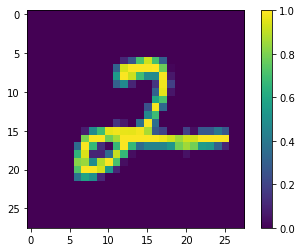

In [ ]:
print(y_valid[0][1])
plt.imshow(x_valid[0][1,:, :,0])
plt.colorbar()

We then perform a PCA on image dataset in order to reduce it size. This will help the calculation.

In [ ]:
x_test

array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
 

In [ ]:
def truncate_x(x_train,x_valid, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_valid = tf.gather(tf.shape(x_valid),0)
  n_points_test = tf.gather(tf.shape(x_test), 0)
  
  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_valid = tf.reshape(x_valid, [n_points_valid, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])
  
  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  feature_mean_valid = tf.reduce_mean(x_valid, axis=0)
  x_valid_normalized = x_valid - feature_mean_valid
  feature_mean_test = tf.reduce_mean(x_test, axis=0)
  x_test_normalized = x_test - feature_mean_test
  
  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  e_values_valid, e_vectors_valid = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_valid_normalized, x_valid_normalized))
  e_values_test, e_vectors_test = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_test_normalized, x_test_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_valid_normalized, e_vectors_valid[:, -n_components:]),\
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors_test[:, -n_components:])

In [ ]:
DATASET_DIM=10
if len(x_train) > 1:
  for i in range(len(x_train)-1):
    x_train[i], x_valid[i], dummy = truncate_x(x_train[i], x_valid[i],x_test, DATASET_DIM)

  x_train[-1], x_valid[-1], x_test = truncate_x(x_train[-1], x_valid[-1],x_test, DATASET_DIM)

else:
  x_train[0], x_valid[0], x_test = truncate_x(x_train[0], x_valid[0],x_test, DATASET_DIM)

In [ ]:
N_TRAIN = 1000
N_VALID = 400
N_TEST = 200
for i in range(len(x_train)):
  x_train[i], x_valid[i] = x_train[i][:N_TRAIN], x_valid[i][:N_VALID]
  y_train[i] ,y_valid[i] = y_train[i][:N_TRAIN],y_valid[i][:N_TEST]

x_test = x_test[:N_TEST]
y_test = y_test[:N_TEST]

print("New number of training examples:", [len(x) for x in x_train])
print("New number of valid examples:", [len(x) for x in x_valid])
print("New number of test examples:", len(x_test))

New number of training examples: [1000, 1000]
New number of valid examples: [400, 400]
New number of test examples: 200


## Creation of a quantum circuit
We now create a quantum circuit in order to create our model

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


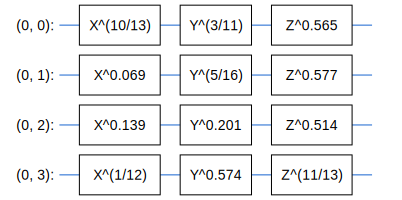

In [ ]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])
  return wall_circuit
  
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3)))) #We put in entry a (1,4) quantum circuit and a random uniform vector

In [ ]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

We test the circuit with 4 qubits and see what happen.

Symbols found in circuit:[ref_0, ref_1, ref_2]


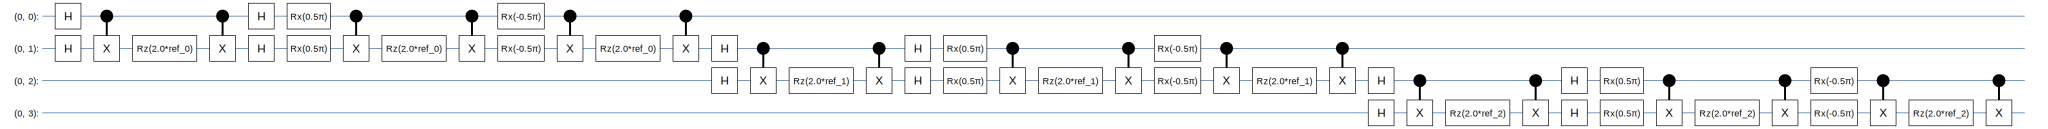

In [ ]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 4))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

In [ ]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

In [ ]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
# one row and dataset_dim+1 columns
q_x_train_circuits, q_x_valid_circuits = [], []
for i in range(len(x_train)):
  q_x_train_circuits.append(prepare_pqk_circuits(qubits, x_train[i]))
  q_x_valid_circuits.append(prepare_pqk_circuits(qubits, x_valid[i]))
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

In [ ]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

x_train_pqk, x_valid_pqk = [], []

for i in range(len(q_x_train_circuits)):
  x_train_pqk.append(get_pqk_features(qubits, q_x_train_circuits[i]))
  x_valid_pqk.append(get_pqk_features(qubits, q_x_valid_circuits[i]))
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
x_train_pqk = np.array(x_train_pqk)
x_valid_pqk = np.array(x_valid_pqk)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK training dataset has shape:', x_valid_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

New PQK training dataset has shape: (2, 1000, 11, 3)
New PQK training dataset has shape: (2, 400, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


In [ ]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [ ]:
S_pqk, V_pqk = [], []

for i in range(len(x_train_pqk)):
  tmp = get_spectrum(
    tf.reshape(tf.concat([x_train_pqk[i], x_valid_pqk[i], x_test_pqk], 0), [-1, len(qubits) * 3]))
  S_pqk.append(tmp[0])
  V_pqk.append(tmp[1])

S_original, V_original = [], []

for i in range(len(x_train)):
  tmp = get_spectrum(
    tf.cast(tf.concat([x_train[i],x_valid[i], x_test], 0), tf.float32), gamma=0.005)
  S_original.append(tmp[0])
  V_original.append(tmp[1])

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: [<tf.Tensor: shape=(1600, 1600), dtype=float32, numpy=
array([[ 0.02117982, -0.00809374, -0.01971107, ...,  0.06933958,
         0.00075517,  0.02462317],
       [ 0.01556711, -0.02922122, -0.05155762, ...,  0.00694025,
         0.72814345,  0.03016593],
       [ 0.02379978,  0.0278071 ,  0.0379183 , ...,  0.6744559 ,
        -0.00443202,  0.0215395 ],
       ...,
       [-0.00340624, -0.02082902, -0.01292629, ...,  0.00291955,
        -0.03802758,  0.01954638],
       [-0.00505369, -0.05562009,  0.00938276, ..., -0.00121394,
        -0.02078181,  0.02831515],
       [-0.00281538, -0.07606452,  0.00274444, ...,  0.00444386,
         0.00586144,  0.03184534]], dtype=float32)>, <tf.Tensor: shape=(1600, 1600), dtype=float32, numpy=
array([[-2.5895875e-02, -9.4531686e-04,  4.6528079e-02, ...,
        -5.6102753e-02, -6.9980661e-04,  2.4708230e-02],
       [-2.2263713e-02, -1.6014937e-02, -3.5111771e-03, ...,
         7.7415630e-03, -7.3093152e-01,  2.2388

In [ ]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [ ]:
y_relabel = []
for i in range(len(S_pqk)):
  y_relabel.append(get_stilted_dataset(S_pqk[i], V_pqk[i], S_original[i], V_original[i]))

y_train_new, y_valid_new = [], [],
for i in range(len(y_relabel)):
  y_train_new.append(y_relabel[i][:N_TRAIN])
  y_valid_new.append(y_relabel[i][N_TRAIN:(N_TRAIN+N_VALID)])
  
y_test_new = y_relabel[0][(N_TRAIN+N_VALID):]

In [ ]:
def create_pqk_model_convolutive(x_train_pqk):
    model = tf.keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1, input_shape=(x_train_pqk.shape[1],x_train_pqk.shape[2],1)))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 1)))
    model.add(layers.Conv2D(8, (3, 1), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def setup_model():
    model = models.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(28,28,1)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(10, activation='softmax'))
    
    # print(model.summary())

    return model

In [ ]:
def train_model(model,x_train,y_train, x_valid, y_valid,epochs):
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
                  
    history = model.fit(x = x_train, y = y_train, epochs=epochs, verbose=0, validation_data=(x_valid, y_valid))
                        #callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                           # patience=1, min_lr=0.00001, verbose=1)])

    # fig, axs = plt.subplots(2)
    # fig.suptitle('Loss and Accuracy of model')
    # axs[0].plot(history.history['loss'], label='loss')
    # axs[0].set_title("loss")
    # axs[1].plot(history.history['accuracy'], label='accuracy')
    # axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
    # axs[1].set_title("Accuracy")
    # plt.xlabel('Epoch')
    # plt.legend(loc='lower right')
    # plt.show()
    # 
    # res = model.evaluate(dataset[2], verbose=2)
    # print(res)

    return model

In [ ]:
def average_models(models, x_train_pqk):
    print('averaging')
    new = np.array(models[0].get_weights())
    for model in models[1:]: new = new + np.array(model.get_weights())
    
    new = new/np.array([len(models)])
        
    new_model = create_pqk_model_convolutive(x_train_pqk)
    new_model.set_weights(new)
    
    return new_model

In [ ]:
#Cellule de test
model_test=create_pqk_model_convolutive(x_train_pqk[0])
model_test.summary()
train_model(model_test,x_train_pqk[0],y_train_new[0],x_valid_pqk[0], y_valid_new[0], 5)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 11, 3, 1)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 1, 16)          160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 1, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 1, 8)           392       
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
model_test.evaluate(x_test_pqk, y_test_new, verbose=2 )

7/7 - 0s - loss: 0.6454 - accuracy: 0.6900
[0.6453928351402283, 0.6899999976158142]


averaging


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging
averaging


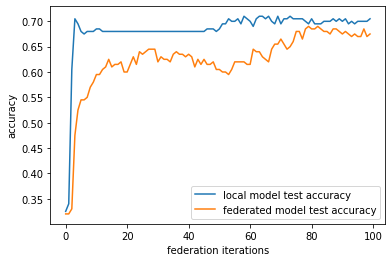

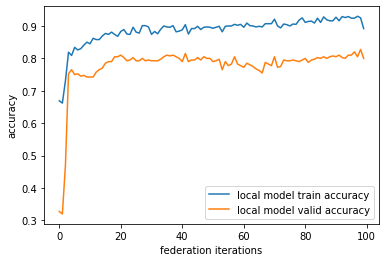

In [ ]:
models = []
nb_clients = len(x_train_pqk)
for _ in range(nb_clients): models.append(create_pqk_model_convolutive(x_train_pqk[0]))
    
eval1 = []
eval2 = []
eval3 = []
eval4 = []
        
for k in range(100):
    for i in range(nb_clients): models[i] = train_model(models[i],x_train_pqk[i],y_train_new[i],x_valid_pqk[i], y_valid_new[i], 5)
    eval1.append(models[0].evaluate(x_test_pqk, y_test_new,verbose=0)[1])
    eval3.append(models[0].evaluate(x_train_pqk[0], y_train_new[0],verbose=0)[1])
    eval4.append(models[0].evaluate(x_valid_pqk[0], y_valid_new[0],verbose=0)[1])
    avg_model = average_models(models, x_train_pqk[0])
    for i in range(nb_clients): models[i].set_weights(avg_model.get_weights())
    eval2.append(models[0].evaluate(x_test_pqk, y_test_new,verbose=0)[1])
            
plt.plot(eval1,label='local model test accuracy')
plt.plot(eval2,label='federated model test accuracy')
plt.xlabel('federation iterations')
plt.ylabel('accuracy')
plt.legend()
    
plt.show()

plt.plot(eval3,label='local model train accuracy')
plt.plot(eval4,label='local model valid accuracy')
plt.xlabel('federation iterations')
plt.ylabel('accuracy')
plt.legend()
    
plt.show()